# 10. 无迹卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

在上一章中，我们讨论了非线性系统带来的困难。这种非线性可以出现在两个方面。它可能存在于我们的测量中，比如雷达测量到的物体的斜距。斜距需要通过平方根计算x、y坐标：

$$x=\sqrt{\text{slant}^2 - \text{altitude}^2}$$

非线性也可能出现在过程模型中——比如我们可能在跟踪一颗穿越空气的球，空气阻力会导致非线性行为。标准的卡尔曼滤波器在这些问题上表现不佳，甚至无法正常工作。

在上一章中，我给你展示了类似这样的图表。我稍微改变了方程以突显非线性的影响。

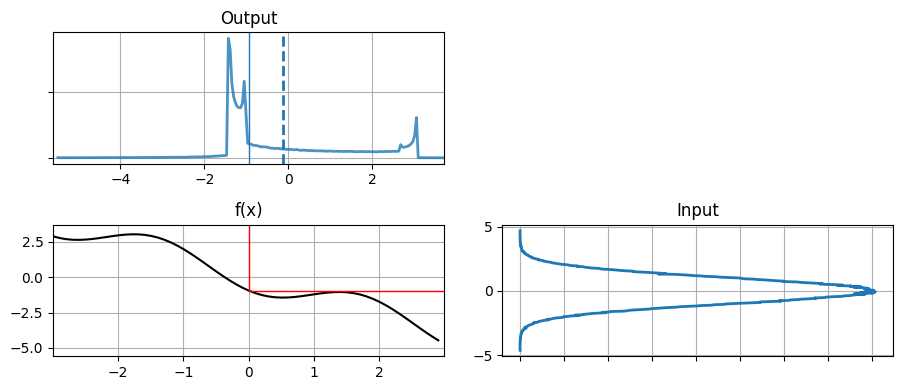

In [3]:
from kf_book.book_plots import set_figsize, figsize
import matplotlib.pyplot as plt
from kf_book.nonlinear_plots import plot_nonlinear_func
from numpy.random import normal
import numpy as np

# create 500,000 samples with mean 0, std 1
gaussian = (0., 1.)
data = normal(loc=gaussian[0], scale=gaussian[1], size=500000)

def f(x):
    return (np.cos(4*(x/2 + 0.7))) - 1.3*x

plot_nonlinear_func(data, f)

我是通过从输入中获取 500,000 个样本，将其通过非线性变换，并构建结果的直方图生成这张图的。我们称这些点为“sigma点”。通过输出的直方图，我们可以计算平均值和标准差，这将给我们一个更新后的、虽然是近似的高斯分布。

让我给你展示一下在通过 `f(x)` 变换之前和之后的数据散点图。

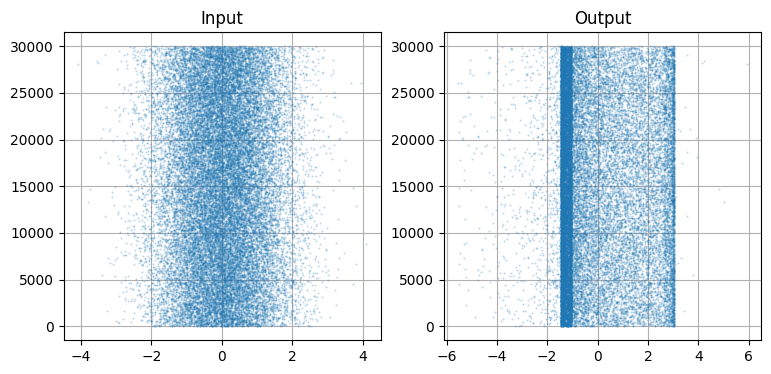

In [4]:
N = 30000
plt.subplot(121)
plt.scatter(data[:N], range(N), alpha=.2, s=1)
plt.title('Input')
plt.subplot(122)
plt.title('Output')
plt.scatter(f(data[:N]), range(N), alpha=.2, s=1);

数据本身呈现出高斯分布的样子，事实上也是如此。我的意思是它看起来像是围绕零均值散布的白噪声。相比之下，`g(data)` 具有明确定义的结构。有两个带状区域，中间有大量的点。在带状区域的外侧有分散的点，但在负数方向有更多的点。

也许你已经想到了，这种采样过程构成了我们问题的解决方案。假设对于每次更新，我们生成了 500,000 个点，经过函数处理，然后计算了结果的均值和方差。这被称为“蒙特卡罗”方法，某些卡尔曼滤波设计中采用了这种方法，比如集合滤波器和粒子滤波器。采样不需要专业知识，也不需要一个封闭的解。只要我们以足够的sigma点进行采样，无论函数多么非线性或行为多么糟糕，我们都能建立一个准确的输出分布。

“足够多的点”是个问题。上面的图是由 500,000 个 sigma 点创建的，但输出仍然不够平滑。更糟糕的是，这仅针对一个维度。所需的点数按维数的幂级数增加。如果对于 1 维度只需要 500 点，那么对于两个维度，就需要 500 的平方，即 250,000 点；对于三个维度，就需要 500 的立方，即 125,000,000 点，依此类推。因此，虽然这种方法确实可行，但计算代价非常高。集合滤波器和粒子滤波器使用巧妙的技术显著降低了这种维度，但计算负担仍然非常大。无迹卡尔曼滤波器使用 sigma 点，但通过使用确定性方法选择这些点来大幅减少计算量。

# sigma点 - 从分布中取样

让我们用一个二维协方差椭圆来看这个问题。我之所以选择二维，只是因为容易绘制；这个概念可以扩展到任意维度。假设有一个任意的非线性函数，我们将从第一个协方差椭圆中取出随机点，通过这个非线性函数进行变换，然后绘制它们的新位置。接着，我们可以计算变换后点的均值和协方差，将其作为我们对均值和概率分布的估计。

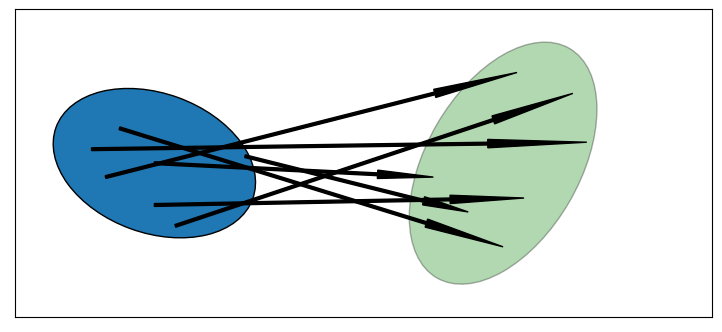

In [5]:
import kf_book.ukf_internal as ukf_internal
ukf_internal.show_2d_transform()

左侧显示了一个椭圆，表示两个状态变量的$1\sigma$分布。箭头显示了一些随机抽样点可能会被某个任意非线性函数转换为一个新的分布。右侧的椭圆是半透明的，表示它是这些点集的*估计*均值和方差。

让我们编写一个函数，将从以下高斯分布中随机抽取的10,000个点经过非线性系统处理：

$$\mu = \begin{bmatrix}0\\0\end{bmatrix}, 
\Sigma=\begin{bmatrix}32&15\\15&40\end{bmatrix}$$

通过非线性系统：

$$\begin{cases}\begin{aligned}\bar x&=x+y\\
\bar y&= 0.1x^2 + y^2\end{aligned} \end{cases}$$

Difference in mean x=-0.105, y=43.210


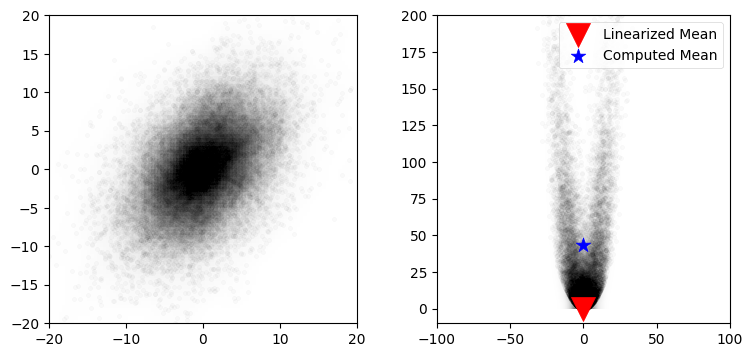

In [7]:
import numpy as np
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_monte_carlo_mean

def f_nonlinear_xy(x, y):
    return np.array([x + y, .1*x**2 + y*y])

mean = (0., 0.)
p = np.array([[32., 15.], [15., 40.]])
# Compute linearized mean
mean_fx = f_nonlinear_xy(*mean)

#generate random points
xs, ys = multivariate_normal(mean=mean, cov=p, size=10000).T
plot_monte_carlo_mean(xs, ys, f_nonlinear_xy, mean_fx, 'Linearized Mean');

这个图展示了这个函数的强非线性特性，以及如果按照扩展卡尔曼滤波器的方式进行线性化，会导致的大误差。我们将在下一章学习这个内容。

# 一个快速的例子

我很快就会开始介绍无迹卡尔曼滤波器（UKF）用来选择sigma点并进行计算的数学方法。但我们先从一个例子开始，这样你就可以看到目标，可以说是这个方法的目的。

我们将学习到，UKF可以使用许多不同的算法来生成sigma点。FilterPy提供了几种算法。这是其中的一个可能性：

In [9]:
from filterpy.kalman import JulierSigmaPoints

sigmas = JulierSigmaPoints(n=2, kappa=1)

稍后会更清楚，但是对于任何给定的均值和协方差，该对象将生成加权的sigma点。让我们看一个例子，其中点的大小表示它们被赋予的权重：

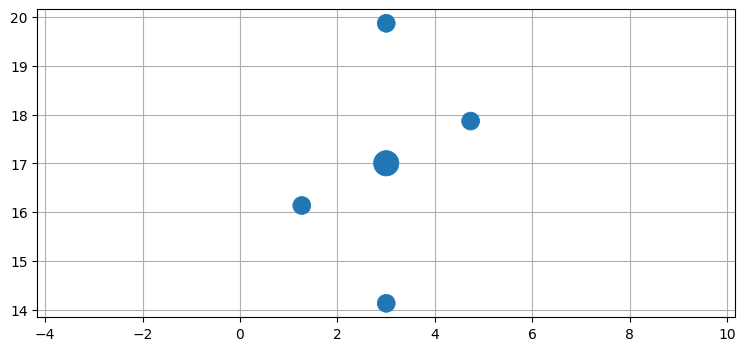

In [10]:
from kf_book.ukf_internal import plot_sigmas
plot_sigmas(sigmas, x=[3, 17], cov=[[1, .5], [.5, 3]])

你可以看到，我们有5个围绕着均值（3，17）的点，呈奇怪的模式分布。可能会觉得这些点会比50万个随机生成的点效果更好，但实际上会的！

好的，现在让我们实现这个滤波器。我们将实现一个标准的1D线性滤波器；我们还没有准备好去处理非线性滤波器。滤波器的设计与我们到目前为止学到的并没有太大区别，只有一个不同点。KalmanFilter类使用矩阵 $\mathbf F$ 来计算状态转移函数。矩阵意味着**线性**代数，适用于线性问题，但不适用于非线性问题。因此，我们不再提供矩阵，而是提供一个函数，就像我们上面所做的那样。KalmanFilter类使用另一个矩阵 $\mathbf H$ 来实现测量函数，将状态转换为相应的测量。同样，矩阵暗示着线性性质，所以我们提供一个函数。或许现在 $\mathbf H$ 为何被称为“测量函数”就清楚了；对于线性卡尔曼滤波器，它是一个矩阵，但那只是一种快速计算一个恰好是线性的函数的方法。

不再多说了，以下是用于1D跟踪问题的状态转移函数和测量函数，其中状态为 $\mathbf x = [x \, \, \dot x]^ \mathsf T$：

In [11]:
def fx(x, dt):
    xout = np.empty_like(x)
    xout[0] = x[1] * dt + x[0]
    xout[1] = x[1]
    return xout

def hx(x):
    return x[:1] # return position [x] 

明确一点，这是一个线性示例。对于线性问题，不需要使用UKF，但我从最简单的例子开始。但请注意，我编写了 `fx()` 来计算 $\mathbf{\bar x}$，用的是一组方程而不是矩阵乘法。这是为了说明我可以在这里实现任意的非线性函数；我们不局限于线性方程。

其余设计与之前一样。设计 $\mathbf P$、$\mathbf R$ 和 $\mathbf Q$。你知道怎么做，让我们完成滤波器并运行它。

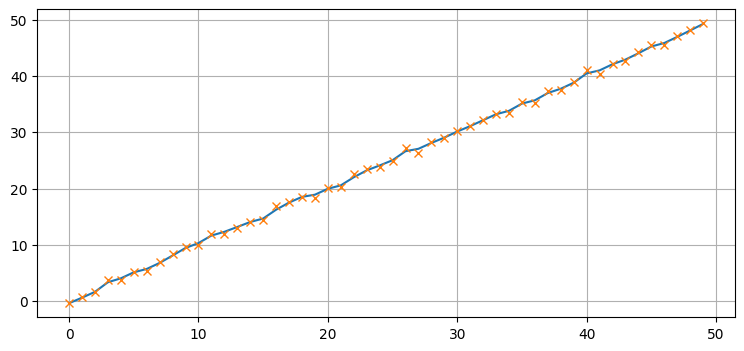

In [12]:
from numpy.random import randn
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

ukf = UnscentedKalmanFilter(dim_x=2, dim_z=1, dt=1., hx=hx, fx=fx, points=sigmas)
ukf.P *= 10
ukf.R *= .5
ukf.Q = Q_discrete_white_noise(2, dt=1., var=0.03)

zs, xs = [], []
for i in range(50):
    z = i + randn()*.5
    ukf.predict()
    ukf.update(z)
    xs.append(ukf.x[0])
    zs.append(z)
    
plt.plot(xs);
plt.plot(zs, marker='x', ls='');